In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
!pip install efficient-apriori
!pip install clustergram
!pip install urbangrammar-graphics==1.2.3
!pip install kmodes
import datetime
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import json

# ПУНКТ 1. Корректность преобразования имеющихся данных и полнота итогового датафрейма.
НЕОБХОДИМОСТЬ ОТФИЛЬТРОВАТЬ ДАННЫЕ  И ОСТАВИТЬ ТОЛЬКО ТЕХ ЛЮДЕЙ, КОТОРЫЕ ОТНОСЯТСЯ К СТРАНЕ С КОДОВЫМ ЦИФРОВЫМ ЗНАЧЕНИЕМ 32.

In [ ]:
cnx = sqlite3.connect('shop_database.db')

In [ ]:
purchases = pd.read_sql_query("SELECT * FROM 'purchases'", cnx)
purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
786258,178004,Пакет,коричневый,12,NaN,0,20


In [ ]:
personal_data_coeffs = pd.read_sql_query("SELECT * FROM 'personal_data_coeffs'", cnx)
personal_data_coeffs

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072
...,...,...,...,...,...
104984,177998,4.740988,0.364797,1.165888,0.5072
104985,177999,7.303172,0.431899,1.317100,0.4304
104986,178001,5.241579,0.430391,0.356182,0.2576
104987,178002,7.542436,-0.290921,0.800338,0.4304


In [ ]:
personal_data = pd.read_csv('personal_data.csv')
personal_data

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32
...,...,...,...,...,...
15743,135183,44,среднее,1134,32
15744,125993,46,среднее,1134,32
15745,167019,71,среднее,1134,32
15746,116355,32,среднее,1188,32


In [ ]:
df1 = purchases.merge(personal_data_coeffs, on='id', how='left')
df1= purchases.merge(personal_data, on='id')
df1

,id,product,colour,cost,product_sex,base_sale,dt,age,education,city,country
0,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,31,среднее,1134,32
1,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,31,среднее,1134,32
2,3,Кеды мужские FILA A-Low,белый,2799,1.0,1,34,31,среднее,1134,32
3,3,Полуботинки мужские Outventure Chase,серый,2999,1.0,0,34,31,среднее,1134,32
4,33,Футболка мужская Kappa Authentic Icon,черный,1699,1.0,0,4,34,среднее,1167,32
...,...,...,...,...,...,...,...,...,...,...,...
116299,177984,Брюки утепленные женские Outventure,чёрный,2099,0.0,1,47,43,среднее,1204,32
116300,177984,Куртка утепленная женская Madshus,сливовый,3499,0.0,1,55,43,среднее,1204,32
116301,178002,Кроссовки мужские Etonic 528 Maestro,серый/белый,5999,1.0,0,0,50,среднее,1188,32
116302,178002,Кеды мужские Reebok Royal Techque T,None,3499,1.0,0,57,50,среднее,1188,32


In [ ]:
df1.isnull().sum()

id                 0
product            0
colour         17619
cost               0
product_sex    46334
base_sale          0
dt                 0
age                0
education          0
city               0
country            0
dtype: int64

In [ ]:
df16=df1.dropna()
df16

,id,product,colour,cost,product_sex,base_sale,dt,age,education,city,country
0,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,31,среднее,1134,32
2,3,Кеды мужские FILA A-Low,белый,2799,1.0,1,34,31,среднее,1134,32
3,3,Полуботинки мужские Outventure Chase,серый,2999,1.0,0,34,31,среднее,1134,32
4,33,Футболка мужская Kappa Authentic Icon,черный,1699,1.0,0,4,34,среднее,1167,32
5,33,Брюки мужские Demix,чёрный,659,1.0,1,6,34,среднее,1167,32
...,...,...,...,...,...,...,...,...,...,...,...
116296,177968,Кроссовки мужские Demix Sprinter Vibe,черный,2099,1.0,1,49,49,высшее,1157,32
116297,177984,Куртка утепленная женская Demix,черный,4499,0.0,1,36,43,среднее,1204,32
116299,177984,Брюки утепленные женские Outventure,чёрный,2099,0.0,1,47,43,среднее,1204,32
116300,177984,Куртка утепленная женская Madshus,сливовый,3499,0.0,1,55,43,среднее,1204,32


# Корректность выполненной классификации.
Проверяющим предоставлены закрытые утерянные данные (пол покупателей). Корректность классификации оценивается с помощью метрики «F-мера»: чем выше её значение, тем выше оценка.

In [ ]:
#модель классификации
df3 = pd.read_csv('personal_data.csv.gz')
df3

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32
...,...,...,...,...,...
15743,135183,44,среднее,1134,32
15744,125993,46,среднее,1134,32
15745,167019,71,среднее,1134,32
15746,116355,32,среднее,1188,32


In [ ]:
df3['product_sex']=df16['product_sex']
df3['personal_coef']=personal_data_coeffs['personal_coef']
df3

,id,age,education,city,country,product_sex,personal_coef
0,101492,32,среднее,1188,32,1.0,0.5072
1,42690,20,высшее,1134,32,NaN,0.4304
2,113001,27,среднее,1187,32,1.0,0.5072
3,163654,49,высшее,1160,32,1.0,0.4304
4,69523,44,среднее,1137,32,1.0,0.5072
...,...,...,...,...,...,...,...
15743,135183,44,среднее,1134,32,NaN,0.5584
15744,125993,46,среднее,1134,32,0.0,0.5584
15745,167019,71,среднее,1134,32,0.0,0.5072
15746,116355,32,среднее,1188,32,0.0,0.4688


In [ ]:
df100=df3.dropna()
df100

,id,age,education,city,country,product_sex,personal_coef
0,101492,32,среднее,1188,32,1.0,0.5072
2,113001,27,среднее,1187,32,1.0,0.5072
3,163654,49,высшее,1160,32,1.0,0.4304
4,69523,44,среднее,1137,32,1.0,0.5072
5,112070,34,высшее,1141,32,1.0,0.5072
...,...,...,...,...,...,...,...
15740,130605,36,среднее,1189,32,1.0,0.5072
15741,38466,61,среднее,1177,32,0.0,0.5072
15744,125993,46,среднее,1134,32,0.0,0.5584
15745,167019,71,среднее,1134,32,0.0,0.5072


In [ ]:
#перекодировка в категориальный
labelencoder = LabelEncoder()

In [ ]:
df100.loc[:, 'education'] = labelencoder.fit_transform(df100.loc[:, 'education'])
df100

,id,age,education,city,country,product_sex,personal_coef
0,101492,32,1,1188,32,1.0,0.5072
2,113001,27,1,1187,32,1.0,0.5072
3,163654,49,0,1160,32,1.0,0.4304
4,69523,44,1,1137,32,1.0,0.5072
5,112070,34,0,1141,32,1.0,0.5072
...,...,...,...,...,...,...,...
15740,130605,36,1,1189,32,1.0,0.5072
15741,38466,61,1,1177,32,0.0,0.5072
15744,125993,46,1,1134,32,0.0,0.5584
15745,167019,71,1,1134,32,0.0,0.5072


In [ ]:
df102=df100[['id', 'personal_coef', 'age', 'product_sex', 'education', 'city', 'country']]
df102

,id,personal_coef,age,product_sex,education,city,country
0,101492,0.5072,32,1.0,1,1188,32
2,113001,0.5072,27,1.0,1,1187,32
3,163654,0.4304,49,1.0,0,1160,32
4,69523,0.5072,44,1.0,1,1137,32
5,112070,0.5072,34,1.0,0,1141,32
...,...,...,...,...,...,...,...
15740,130605,0.5072,36,1.0,1,1189,32
15741,38466,0.5072,61,0.0,1,1177,32
15744,125993,0.5584,46,0.0,1,1134,32
15745,167019,0.5072,71,0.0,1,1134,32


In [ ]:
#линейная регрессия

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df102.shape

(8126, 7)

In [ ]:
X=df102.drop(columns=['product_sex', 'personal_coef', 'id'], axis=1)
y=df102['product_sex']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
X_train

,age,education,city,country
6047,52,1,1183,32
3790,59,1,1181,32
895,49,1,1134,32
5334,32,1,1153,32
15249,39,1,1157,32
...,...,...,...,...
14495,28,1,1179,32
12127,51,1,1134,32
3779,46,1,1188,32
10932,52,1,1134,32


In [ ]:
print(f"Классы в y_train:\n{y_train}")
print(f"Классы в y_test:\n{y_test}")

Классы в y_train:
6047     0.0
3790     1.0
895      1.0
5334     1.0
15249    1.0
        ... 
14495    1.0
12127    1.0
3779     1.0
10932    1.0
11248    0.0
Name: product_sex, Length: 5688, dtype: float64
Классы в y_test:
11467    0.0
11889    0.0
5        1.0
339      1.0
2549     1.0
        ... 
6174     1.0
6573     1.0
13598    0.0
3060     0.0
2935     1.0
Name: product_sex, Length: 2438, dtype: float64


In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

In [ ]:
clf=RandomForestClassifier()

In [ ]:
y_pred = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
#f1_score у линейной регрессии
df9=f1_score(y_test, y_pred)
df9

0.5830676585193058

In [ ]:
#модель классификации
df40 = pd.read_csv('personal_data.csv.gz')
df40

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32
...,...,...,...,...,...
15743,135183,44,среднее,1134,32
15744,125993,46,среднее,1134,32
15745,167019,71,среднее,1134,32
15746,116355,32,среднее,1188,32


In [ ]:
df40['product_sex']=df16['product_sex']
df40['personal_coef']=personal_data_coeffs['personal_coef']
df40

,id,age,education,city,country,product_sex,personal_coef
0,101492,32,среднее,1188,32,1.0,0.5072
1,42690,20,высшее,1134,32,NaN,0.4304
2,113001,27,среднее,1187,32,1.0,0.5072
3,163654,49,высшее,1160,32,1.0,0.4304
4,69523,44,среднее,1137,32,1.0,0.5072
...,...,...,...,...,...,...,...
15743,135183,44,среднее,1134,32,NaN,0.5584
15744,125993,46,среднее,1134,32,0.0,0.5584
15745,167019,71,среднее,1134,32,0.0,0.5072
15746,116355,32,среднее,1188,32,0.0,0.4688


In [ ]:
df40[['product_sex']] = df40[['product_sex']]. fillna (value= df9 )
df40

,id,age,education,city,country,product_sex,personal_coef
0,101492,32,среднее,1188,32,1.000000,0.5072
1,42690,20,высшее,1134,32,0.583068,0.4304
2,113001,27,среднее,1187,32,1.000000,0.5072
3,163654,49,высшее,1160,32,1.000000,0.4304
4,69523,44,среднее,1137,32,1.000000,0.5072
...,...,...,...,...,...,...,...
15743,135183,44,среднее,1134,32,0.583068,0.5584
15744,125993,46,среднее,1134,32,0.000000,0.5584
15745,167019,71,среднее,1134,32,0.000000,0.5072
15746,116355,32,среднее,1188,32,0.000000,0.4688


In [ ]:
df40['product_sex'] = df40['product_sex'].astype (int)
df40

,id,age,education,city,country,product_sex,personal_coef
0,101492,32,среднее,1188,32,1,0.5072
1,42690,20,высшее,1134,32,0,0.4304
2,113001,27,среднее,1187,32,1,0.5072
3,163654,49,высшее,1160,32,1,0.4304
4,69523,44,среднее,1137,32,1,0.5072
...,...,...,...,...,...,...,...
15743,135183,44,среднее,1134,32,0,0.5584
15744,125993,46,среднее,1134,32,0,0.5584
15745,167019,71,среднее,1134,32,0,0.5072
15746,116355,32,среднее,1188,32,0,0.4688


# выводы:
1.для модели используются: возраст и образование

2.для прогнозирования product_sex

по результатам f1_score что у случайного леса, что у линейной регрессии результаты сильно не отличаются поэтому можно использовать два метода.

# пункт 3.A/B-тестирование
Проанализировать, насколько первая маркетинговая кампания была эффективна. Для проведения A/B-тестирования, помимо людей, которым предлагалась персональная скидка, были отобраны люди со схожими социально-демографическими признаками и покупками, которым скидку не предложили. Провести расчёт A/B-теста и посчитать значения основных метрик. Сделать бизнес-рекомендацию и обосновать её.

Первая маркентинговая компания проводилась с  5-го по 16-й день, содержатся в файле ids_first_company_positive.txt

Вторая кампания проводилась на жителях города 1 134 и представляла собой баннерную рекламу на билбордах: скидка всем каждое 15-е число месяца (15-й и 45-й день в нашем случае).


In [ ]:
df40['base_sale']= purchases['base_sale']
df40['cost']= purchases['cost']
df40

,id,age,education,city,country,product_sex,personal_coef,base_sale,cost
0,101492,32,среднее,1188,32,1,0.5072,1,13599
1,42690,20,высшее,1134,32,0,0.4304,0,1499
2,113001,27,среднее,1187,32,1,0.5072,0,4799
3,163654,49,высшее,1160,32,1,0.4304,0,1599
4,69523,44,среднее,1137,32,1,0.5072,0,7199
...,...,...,...,...,...,...,...,...,...
15743,135183,44,среднее,1134,32,0,0.5584,0,1599
15744,125993,46,среднее,1134,32,0,0.5584,0,599
15745,167019,71,среднее,1134,32,0,0.5072,1,4199
15746,116355,32,среднее,1188,32,0,0.4688,0,18999


In [ ]:
df40['personal_coef']=personal_data_coeffs['personal_coef']
df40

,id,age,education,city,country,product_sex,personal_coef,base_sale,cost
0,101492,32,среднее,1188,32,1,0.5072,1,13599
1,42690,20,высшее,1134,32,0,0.4304,0,1499
2,113001,27,среднее,1187,32,1,0.5072,0,4799
3,163654,49,высшее,1160,32,1,0.4304,0,1599
4,69523,44,среднее,1137,32,1,0.5072,0,7199
...,...,...,...,...,...,...,...,...,...
15743,135183,44,среднее,1134,32,0,0.5584,0,1599
15744,125993,46,среднее,1134,32,0,0.5584,0,599
15745,167019,71,среднее,1134,32,0,0.5072,1,4199
15746,116355,32,среднее,1188,32,0,0.4688,0,18999


In [ ]:
#перекодировка в категориальный
labelencoder = LabelEncoder()

In [ ]:
df40.loc[:, 'education'] = labelencoder.fit_transform(df40.loc[:, 'education'])
df40

,id,age,education,city,country,product_sex,personal_coef,base_sale,cost
0,101492,32,1,1188,32,1,0.5072,1,13599
1,42690,20,0,1134,32,0,0.4304,0,1499
2,113001,27,1,1187,32,1,0.5072,0,4799
3,163654,49,0,1160,32,1,0.4304,0,1599
4,69523,44,1,1137,32,1,0.5072,0,7199
...,...,...,...,...,...,...,...,...,...
15743,135183,44,1,1134,32,0,0.5584,0,1599
15744,125993,46,1,1134,32,0,0.5584,0,599
15745,167019,71,1,1134,32,0,0.5072,1,4199
15746,116355,32,1,1188,32,0,0.4688,0,18999


In [ ]:
#Открытие файла(позитив)
with open('ids_first_company_positive.txt', 'r') as file:
     content_positive = file.read()

In [ ]:
# Преобразование разделителей
content_positive = content_positive.replace(',', ';').replace(' ', ';').replace('\n', '').split(';')

In [ ]:
#Создание
positive_df = pd.DataFrame(content_positive, columns=['id'])

In [ ]:
# Оставляем только числовые значения ID
positive_df = positive_df[positive_df['id'].str.isnumeric()]

In [ ]:
# Преобразуем ID в числовой формат
positive_df['id'] = positive_df['id'].astype('int64')
positive_df

,id
5,88128
6,171960
7,142117
8,114589
9,146123
...,...
5000,20387
5001,61130
5002,18359
5003,87690


In [ ]:
# Добавляем столбец "group" для положительных клиентов
positive_df['group'] = 'test'
positive_df

,id,group
5,88128,test
6,171960,test
7,142117,test
8,114589,test
9,146123,test
...,...,...
5000,20387,test
5001,61130,test
5002,18359,test
5003,87690,test


In [ ]:
#Открытие файла(негатив)
with open('ids_first_company_negative.txt', 'r') as file2:
     content_negative = file2.read()

In [ ]:
# Преобразование разделителей
content_negative = content_negative.replace(',', ';').replace(' ', ';').replace('\n', '').split(';')

In [ ]:
#Создание
negative_df = pd.DataFrame(content_negative, columns=['id'])

In [ ]:
# Оставляем только числовые значения ID
negative_df = negative_df[negative_df['id'].str.isnumeric()]

In [ ]:
# Преобразуем ID в числовой формат
negative_df['id'] = negative_df['id'].astype('int64')
negative_df

,id
5,82450
6,63400
7,7138
8,102118
9,153511
...,...
6021,89121
6022,161445
6023,162570
6024,92547


In [ ]:
# Добавляем столбец "group" для положительных клиентов
negative_df['group'] = 'control'
negative_df

,id,group
5,82450,control
6,63400,control
7,7138,control
8,102118,control
9,153511,control
...,...,...
6021,89121,control
6022,161445,control
6023,162570,control
6024,92547,control


In [ ]:
#Негатив
df_AB = pd.merge(df40, negative_df, on='id')
df_AB

,id,age,education,city,country,product_sex,personal_coef,base_sale,cost,group
0,106251,43,1,1158,32,1,0.4304,0,999,control
1,122393,24,0,1177,32,1,0.2672,0,3499,control
2,141016,41,1,1177,32,0,0.5072,1,499,control
3,155965,35,1,1177,32,0,0.4304,0,4999,control
4,171554,56,1,1183,32,1,0.4688,0,13299,control
...,...,...,...,...,...,...,...,...,...,...
758,78883,14,0,1147,32,0,0.5072,0,299,control
759,37503,41,1,1167,32,0,0.4304,0,24999,control
760,121124,38,1,1134,32,0,0.4688,1,6399,control
761,11558,33,1,1185,32,0,0.4304,0,2399,control


In [ ]:
df_AB.isnull().sum()

id               0
age              0
education        0
city             0
country          0
product_sex      0
personal_coef    0
base_sale        0
cost             0
group            0
dtype: int64

In [ ]:
#позитив
dfAB = pd.merge(df40, positive_df, on='id')
dfAB

,id,age,education,city,country,product_sex,personal_coef,base_sale,cost,group
0,113001,27,1,1187,32,1,0.5072,0,4799,test
1,120841,34,1,1204,32,0,0.5072,0,1499,test
2,79732,38,1,1204,32,0,0.4304,0,8799,test
3,17942,57,1,1175,32,0,0.5072,0,1599,test
4,159915,19,0,1134,32,0,0.4304,1,8399,test
...,...,...,...,...,...,...,...,...,...,...
750,122890,36,1,1134,32,1,0.4304,1,649,test
751,53736,41,1,1134,32,0,0.4688,0,6399,test
752,165252,35,1,1188,32,0,0.4304,0,1799,test
753,105219,46,0,1134,32,0,0.5072,0,2399,test


In [ ]:
dfAB.isnull().sum()

id               0
age              0
education        0
city             0
country          0
product_sex      0
personal_coef    0
base_sale        0
cost             0
group            0
dtype: int64

In [ ]:
#общий датасет
df30 = df40[["id", "base_sale"]]
df30

,id,base_sale
0,101492,1
1,42690,0
2,113001,0
3,163654,0
4,69523,0
...,...,...
15743,135183,0
15744,125993,0
15745,167019,1
15746,116355,0


In [ ]:
#проверка на нормальность столбца 'base_sale'
from scipy import stats
res = stats.shapiro(df30)
res.statistic

C:\Milena\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.7639158964157104

In [ ]:
# негатив
df31 = df_AB[["id", "base_sale"]]
df31

,id,base_sale
0,106251,0
1,122393,0
2,141016,1
3,155965,0
4,171554,0
...,...,...
758,78883,0
759,37503,0
760,121124,1
761,11558,0


In [ ]:
#проверка на нормальность столбца 'base_sale'
from scipy import stats
res = stats.shapiro(df31)
res.statistic

0.7619181871414185

In [ ]:
#позитив
df32 = dfAB[["id", "base_sale"]]
df32

,id,base_sale
0,113001,0
1,120841,0
2,79732,0
3,17942,0
4,159915,1
...,...,...
750,122890,1
751,53736,0
752,165252,0
753,105219,0


In [ ]:
#проверка на нормальность столбца 'base_sale'
from scipy import stats
res = stats.shapiro(df32)
res.statistic

0.7659227252006531

In [ ]:
x = np.array([15748,763,755])

In [ ]:
#сравнивание групп на нормальность
from scipy import stats
res = stats.shapiro(x)
res.statistic

0.7504002451896667

In [ ]:
control = [763]
test = [755]

In [ ]:
from scipy.stats import mannwhitneyu
pnorm = mannwhitneyu(control, test, method="asymptotic")
print(pnorm)

MannwhitneyuResult(statistic=1.0, pvalue=1.0)


In [ ]:
#t-test
stats.ttest_ind(a=df31, b=df32, equal_var=True)

TtestResult(statistic=array([ 1.14662299, -0.6346335 ]), pvalue=array([0.25171841, 0.52576323]), df=array([1516., 1516.]))

In [ ]:
#средний чек для позитивной маркетинговой компании
dfAB["base_sale"].sum()

269

In [ ]:
#средний чек для негативной компании
df_AB["base_sale"].sum()

260

In [ ]:
#средний чек общего датасета
df40["base_sale"].sum()

5588

# вывод
1.по статистике нулевая гипотеза равна между группами

2.после проведения теста Манна-Уитни подтверждено что значения у групп одинаковы

3.по решению t-test, гипотеза отвергается. Так как значение выше 0,05

4.средний чек в позитивной компании выше, чем у негативной, а в общем составил высокий результат. Поэтому результаты в среднем чеке хорошие

5.если рассматривать в позитивном влиянии на бизнес, то клиентов в позитиве больше и высокий спрос

6.если рассматривать в негативном влиянии на бизнес, клиентов меньше и спроса не будет

7.если брать по рельзутьтам теста то лучше всего будет позитивное, т.к. спрос будет большим, в негативе лучше всего наблюдать, проводить тесты и улучшать.

# ЗАДАНИЕ 4
выяснить, на какие кластеры разбивается аудитория, и предложить методы работы с каждым кластером. Обратить внимание, что количество кластеров необходимо выбрать самостоятельно. В итоговом анализе должна содержаться информация о том, какие товары предпочитают различные кластеры клиентов и насколько на покупку влияет наличие скидки.

In [ ]:
# Проведем нормализацию данных. Будем нормализовывать все признаки кроме Response
# Выбираем метод стандартизации т.к. он менее чувствителен к аномалиям
stdscaler = StandardScaler()

In [ ]:
personal_data_coeffs

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072
...,...,...,...,...,...
104984,177998,4.740988,0.364797,1.165888,0.5072
104985,177999,7.303172,0.431899,1.317100,0.4304
104986,178001,5.241579,0.430391,0.356182,0.2576
104987,178002,7.542436,-0.290921,0.800338,0.4304


In [ ]:
personal_data_coeffs.columns

Index(['id', 'lbt_coef', 'ac_coef', 'sm_coef', 'personal_coef'], dtype='object')

In [ ]:
columns_for_std = ['id', 'lbt_coef', 'ac_coef', 'sm_coef', 'personal_coef']

In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
#Воспользуемся функцией make_blobs, чтобы получить фиктивные данные,
#Который имеет 2 показателя и 4 кластера
#Модели кластеризации методом K-средних
df8 = make_blobs(
    n_samples = 100,
    n_features = 2,
    centers = 4,
    cluster_std = 1.8
)

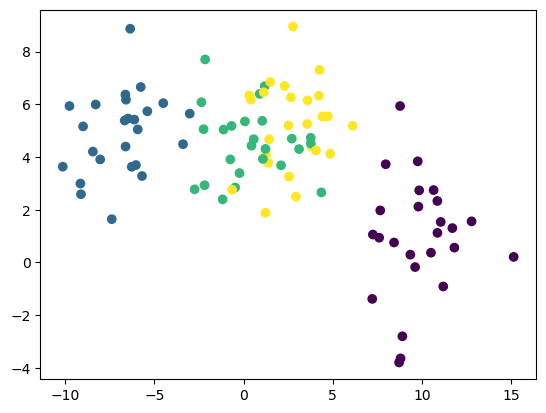

In [ ]:
#при построении будут использоваться цвет для каждого кластера
plt.scatter(df8[0][:,0], df8[0][:,1], c=df8[1]);

In [ ]:
#присвоение переменной model
#применение kmeans
model = KMeans(n_clusters=4)

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
#Теперь можно обучить модель, вызвав на ней метод fit и передав первый элемент
model.fit(df8[0])

KMeans(n_clusters=4)

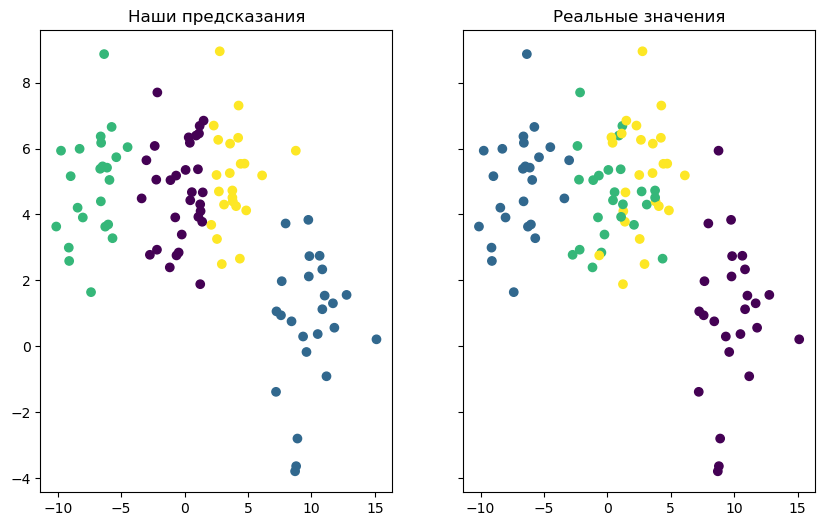

In [ ]:
#визуализация точности модели
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
ax1.set_title('Наши предсказания')
ax1.scatter(df8[0][:,0], df8[0][:,1],c=model.labels_)
ax2.set_title('Реальные значения')
ax2.scatter(df8[0][:,0], df8[0][:,1],c=df8[1]);

In [ ]:
df_numerical=personal_data_coeffs[['id', 'personal_coef']]
df_numerical

,id,personal_coef
0,0,0.5072
1,3,0.4304
2,4,0.5072
3,6,0.4304
4,7,0.5072
...,...,...
104984,177998,0.5072
104985,177999,0.4304
104986,178001,0.2576
104987,178002,0.4304


In [ ]:
scaler = StandardScaler()
df_ss_numerical=scaler.fit_transform(df_numerical)

<Axes: >

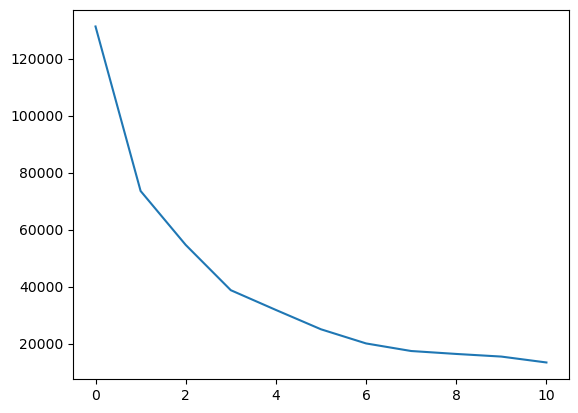

In [ ]:
#метод локтя
n_clusters = list(range(2, 13))

metrics_elbow = []

for k in n_clusters:
    km = KMeans(n_clusters=k, n_init='auto', random_state=1).fit(df_ss_numerical)
    metrics_elbow.append(km.inertia_)

sns.lineplot( metrics_elbow)

In [ ]:
km_model = KMeans(n_clusters=2, n_init='auto', random_state=1)
km = km_model.fit(df_ss_numerical)

In [ ]:
#добавление кластеров
df_numerical['clusters'] = km.labels_
df_numerical

,id,personal_coef,clusters
0,0,0.5072,0
1,3,0.4304,0
2,4,0.5072,0
3,6,0.4304,0
4,7,0.5072,0
...,...,...,...
104984,177998,0.5072,1
104985,177999,0.4304,1
104986,178001,0.2576,1
104987,178002,0.4304,1


In [ ]:
features = ['id', 'personal_coef']

df_han = df_numerical.groupby('clusters').agg({x: ['mean', 'std'] for x in features}).T
df_han

clusters                       0              1
id            mean  44510.552217  133525.696936
              std   25778.074567   25699.655049
personal_coef mean      0.458360       0.458367
              std       0.062617       0.062523

In [ ]:
functions = ['mean', 'std']

stat = np.array([[df_numerical[feature].apply(f) for f in functions] for feature in features]).flatten()

df_skz = df_han.copy()
df_skz['Global'] = stat
df_skz

clusters                       0              1        Global
id            mean  44510.552217  133525.696936  89084.680967
              std   25778.074567   25699.655049  51414.198487
personal_coef mean      0.458360       0.458367      0.458363
              std       0.062617       0.062523      0.062570

In [ ]:
cluster_labels = [0, 1]

for label in cluster_labels:
    df_skz[label] = 100 * df_skz[label] / df_skz['Global'] - 100

df_skz

clusters                    0          1        Global
id            mean -50.035683  49.886260  89084.680967
              std  -49.861954 -50.014479  51414.198487
personal_coef mean  -0.000839   0.000837      0.458363
              std    0.075805  -0.074684      0.062570

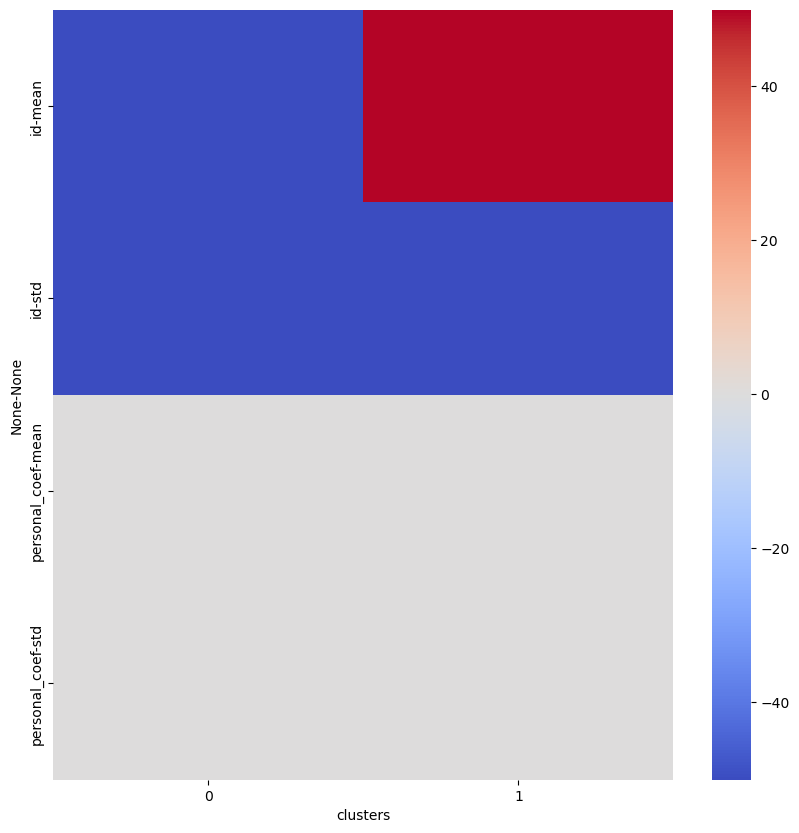

In [ ]:
fig = plt.subplots(figsize=(10,10))
fig = sns.heatmap(df_skz[cluster_labels], cmap='coolwarm')

# вывод

При анализе диаграммы сразу бросается в глаза, что покупатели в кластере 1 потратили больше на разные виды продуктов, чем в кластере 0 т.е. покупатели из кластера 1 наиболее активны с точки зрения покупок. Покупатели кластера 0 покупают товаров больше, как онлайн, так и оффлайн. Покупатели кластера 1 более восприимчивы к ракламным кампаниям, чем клиенты из категории 0. Покупатели кластера 1 - это наши главные клиенты, поэтому следует максимизировать прибыль получаемую от данных клиентов. Покупатели кластера 0 - сложные, объем их покупок очень низкий. Необходимо поработать над их активностью путем, например, индивидуальных предложений.

# ЗАДАНИЕ 5
Модель склонности клиента к покупке.

Необходимо построить модель склонности клиента к покупке определённого товара при коммуникации, основанную на данных о профилях клиентов, данных товаров и данных о прошлых маркетинговых кампаниях.

Последовательность в машинном обучении:
1.открытие файла

2.наименование данных и деление

3.удаление не нужного столбца

4.перекодировка в категориальные

5.приводимость числа в рандомном порядке

6.данные которые прогнозируются

7.разделение данных на тестовые и тренировочные

8.модель для машинного обучения

9.линейная регрессия

10.случайный лес

11.результаты линейной регресси и случайного леса

12.вывод

In [ ]:
purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
786258,178004,Пакет,коричневый,12,NaN,0,20


In [ ]:
#наименование данных и деление
purchases['product1'] = purchases['product'].apply(lambda x: x.split(' '))

In [ ]:
#берётся первое слово в данных
purchases['product']=purchases['product'].apply(lambda x: x[0])
purchases

,id,product,colour,cost,product_sex,base_sale,dt,product1
0,0,В,белый/синий,13599,0.0,1,7,"[Велосипед, горный, женский, Stern, Mira, 2.0,..."
1,0,С,зелёный,1499,NaN,0,37,"[Стол, Outventure]"
2,0,Н,бежевый,4799,NaN,0,37,"[Набор, Outventure:, стол, +, 4, стула]"
3,3,Б,белый,1599,1.0,0,13,"[Бутсы, мужские, GSD, Astro]"
4,3,М,мультицвет,7199,NaN,0,27,"[Мяч, футбольный, PUMA, TEAMFINAL, 21.2, FIFA,..."
...,...,...,...,...,...,...,...,...
786255,178004,П,хаки/черный,7999,1.0,0,12,"[Полуботинки, мужские, Ascot, Vortex]"
786256,178004,К,черный/серый,24299,1.0,0,13,"[Кроссовки, мужские, Nike, Air, Max, 90]"
786257,178004,К,черный/серый,24299,1.0,0,20,"[Кроссовки, мужские, Nike, Air, Max, 90]"
786258,178004,П,коричневый,12,NaN,0,20,[Пакет]


In [ ]:
#удаление столбца product
del purchases['product']

In [ ]:
purchases

,id,colour,cost,product_sex,base_sale,dt,product1
0,0,белый/синий,13599,0.0,1,7,"[Велосипед, горный, женский, Stern, Mira, 2.0,..."
1,0,зелёный,1499,NaN,0,37,"[Стол, Outventure]"
2,0,бежевый,4799,NaN,0,37,"[Набор, Outventure:, стол, +, 4, стула]"
3,3,белый,1599,1.0,0,13,"[Бутсы, мужские, GSD, Astro]"
4,3,мультицвет,7199,NaN,0,27,"[Мяч, футбольный, PUMA, TEAMFINAL, 21.2, FIFA,..."
...,...,...,...,...,...,...,...
786255,178004,хаки/черный,7999,1.0,0,12,"[Полуботинки, мужские, Ascot, Vortex]"
786256,178004,черный/серый,24299,1.0,0,13,"[Кроссовки, мужские, Nike, Air, Max, 90]"
786257,178004,черный/серый,24299,1.0,0,20,"[Кроссовки, мужские, Nike, Air, Max, 90]"
786258,178004,коричневый,12,NaN,0,20,[Пакет]


In [ ]:
purchases.isnull().sum()

id                  0
colour         119524
cost                0
product_sex    314712
base_sale           0
dt                  0
product1            0
dtype: int64

In [ ]:
df90=purchases.dropna()
df90

,id,colour,cost,product_sex,base_sale,dt,product1
0,0,белый/синий,13599,0.0,1,7,"[Велосипед, горный, женский, Stern, Mira, 2.0,..."
3,3,белый,1599,1.0,0,13,"[Бутсы, мужские, GSD, Astro]"
5,3,белый,2799,1.0,1,34,"[Кеды, мужские, FILA, A-Low]"
6,3,серый,2999,1.0,0,34,"[Полуботинки, мужские, Outventure, Chase]"
15,6,черный,4799,1.0,1,3,"[Кеды, мужские, Reebok, Royal, Complete, Cln2]"
...,...,...,...,...,...,...,...
786252,178004,серый/белый/черный,13999,1.0,0,6,"[Кроссовки, мужские, Nike, Air, Max, Sc]"
786255,178004,хаки/черный,7999,1.0,0,12,"[Полуботинки, мужские, Ascot, Vortex]"
786256,178004,черный/серый,24299,1.0,0,13,"[Кроссовки, мужские, Nike, Air, Max, 90]"
786257,178004,черный/серый,24299,1.0,0,20,"[Кроссовки, мужские, Nike, Air, Max, 90]"


In [ ]:
df90_random = df90.sample(frac=0.5)
df90_random

,id,colour,cost,product_sex,base_sale,dt,product1
422079,96053,белый,1299,0.0,1,39,"[Футболка, женская, Columbia, North, Cascades,..."
124924,28032,черный,4199,1.0,1,30,"[Худи, мужская, New, Era, MLB, New, York, Yank..."
536956,121521,темно-серый,1299,1.0,0,14,"[Футболка, мужская, оверсайз, Demix]"
427665,97328,темно-красный,6499,1.0,0,15,"[Кроссовки, мужские, Kappa, Falcade]"
713177,161464,черный/черный,5459,1.0,1,14,"[Кроссовки, мужские, ASICS, Trail, Scout, 2]"
...,...,...,...,...,...,...,...
624448,141100,светло-коричневый,1299,0.0,1,15,"[Футболка, женская, Freddy]"
640029,144649,белый,5499,0.0,0,48,"[Сандалии, женские, FILA, Disruptor, Sandal]"
436,101,бежевый,7499,0.0,0,14,"[Джемпер, флисовый, женский, CMP]"
497884,112785,белый,3599,1.0,0,25,"[Футболки, мужские, Champion,, 2, штуки]"


In [ ]:
#перекодировка в категориальный
labelencoder = LabelEncoder()

In [ ]:
df90.loc[:, 'colour'] = labelencoder.fit_transform(df90.loc[:, 'colour'])
df90

,id,colour,cost,product_sex,base_sale,dt,product1
0,0,162,13599,0.0,1,7,"[Велосипед, горный, женский, Stern, Mira, 2.0,..."
3,3,69,1599,1.0,0,13,"[Бутсы, мужские, GSD, Astro]"
5,3,69,2799,1.0,1,34,"[Кеды, мужские, FILA, A-Low]"
6,3,712,2999,1.0,0,34,"[Полуботинки, мужские, Outventure, Chase]"
15,6,996,4799,1.0,1,3,"[Кеды, мужские, Reebok, Royal, Complete, Cln2]"
...,...,...,...,...,...,...,...
786252,178004,724,13999,1.0,0,6,"[Кроссовки, мужские, Nike, Air, Max, Sc]"
786255,178004,988,7999,1.0,0,12,"[Полуботинки, мужские, Ascot, Vortex]"
786256,178004,1101,24299,1.0,0,13,"[Кроссовки, мужские, Nike, Air, Max, 90]"
786257,178004,1101,24299,1.0,0,20,"[Кроссовки, мужские, Nike, Air, Max, 90]"


In [ ]:
#приводимость число в рандомном порядке
df91_random = df90.sample(frac=0.5)
df91_random

,id,colour,cost,product_sex,base_sale,dt,product1
595586,134719,69,15999,0.0,0,10,"[Велосипед, горный, женский, Denton, Aura, 1.0..."
357984,81595,474,849,0.0,1,12,"[Легинсы, женские, Demix]"
735131,166313,918,3999,1.0,0,4,"[Полуботинки, мужские, Northland, Rand]"
219286,49778,996,1889,0.0,1,28,"[Брюки, женские, Demix]"
198111,44689,575,4799,0.0,1,53,"[Полуботинки, женские, Merrell, Flora, Lace, B..."
...,...,...,...,...,...,...,...
505837,114449,996,12999,1.0,0,2,"[Полуботинки, мужские, Merrell, Speed, Strike,..."
259642,59215,561,699,0.0,1,4,"[Футболка, женская, Demix]"
338142,77312,417,1399,1.0,0,29,"[Шорты, плавательные, мужские, Joss]"
409926,93256,689,6499,0.0,0,5,"[Сандалии, женские, Skechers, Arch, Fit]"


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df91_random.shape

(197444, 7)

In [ ]:
#данные которые прогнозируются
X=df91_random.drop(columns=['product1'], axis=1)
y=df91_random['product1']

In [ ]:
#Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
X_train

,id,colour,cost,product_sex,base_sale,dt
754740,171025,1150,5199,1.0,1,52
589158,133321,650,4499,0.0,0,0
412435,93820,905,1299,1.0,0,23
249465,56759,1003,2299,1.0,0,53
84235,18926,351,25899,1.0,0,15
...,...,...,...,...,...,...
328609,75109,326,2449,0.0,1,24
536341,121396,792,1119,0.0,1,51
126322,28312,1156,1399,1.0,0,49
257291,58678,918,999,1.0,0,32


# модель для машинного обучения

In [ ]:
print(f"Классы в y_train:\n{y_train}")
print(f"Классы в y_test:\n{y_test}")

Классы в y_train:
754740          [Кроссовки, мужские, Nike, Air, Max, Sc]
589158             [Кеды, женские, Demix, Courtmax, CNV]
412435                   [Футболка, мужская, Outventure]
249465          [Шорты, мужские, Nike, Dri-FIT, Academy]
84235     [Ботинки, мужские, Salomon, Quest, 4D, 3, GTX]
                               ...                      
328609                            [Брюки, женские, FILA]
536341            [Шорты, плавательные, женские, Termit]
126322                           [Шорты, мужские, Demix]
257291                             [Брюки, мужские, GSD]
446558                          [Брюки, женские, Termit]
Name: product1, Length: 138210, dtype: object
Классы в y_test:
320147                         [Брюки, мужские, Outventure]
517232    [Ботинки, утепленные, женские, Columbia, Firec...
241977    [Ветровка, мужская, Columbia, Flash, Challenge...
762336    [Лонгслив, мужской, Mountain, Hardwear, High, ...
497271                   [Слипоны, мужские, Termit, 

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Линейная регрессия

In [ ]:
#реализация линеной регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

In [ ]:
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [ ]:
print(lr_train_mse)

2.9987114003486255


In [ ]:
lr_results = pd.DataFrame(['Linear regression',lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2']

In [ ]:
#результаты линейной регрессии
lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,2.998711,0.634213,435754.4479,-53084.282719


# Случайный лес

In [ ]:
#реализация случайного леса
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=2, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=42)

In [ ]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

In [ ]:
y_rf_test_pred

array([6.53214881, 2.71378718, 5.43052911, ..., 5.41044576, 3.39448271,
       4.22204619])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [ ]:
rf_results = pd.DataFrame(['Random forest',rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2']

In [ ]:
#результаты машинного обучения
rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random forest,4.314091,0.473762,4.933253,0.399012


In [ ]:
#результаты линейной регресии и случайного леса
pd.concat([lr_results, rf_results])

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,2.998711,0.634213,435754.4479,-53084.282719
0,Random forest,4.314091,0.473762,4.933253,0.399012


# вывод:

1.по результатам машинного обучения данные имеют хорошие рузультаты

2.самые большие результаты вышли у Random forest(случайный лес), а значит что результаты будут расти

3.Недостатки линейной регрессии заключается в том что низкая точность данных и низкая адаптивность, преимущества в точности с линейной зависимостью в данных, в нашем случае результаты ниже чем у случайного леса

4.В случайном лесе прогнозы коррелируют друг с другом слабо, в нашем случае они коррелируют между собой хорошо, но это также может повлиять на результаты
